In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ganette import Ganette
from imagine.color import conversion
from imagine.functional import functional as f
import itertools
from sklearn.model_selection import cross_val_score

### Loading data

In [2]:
df = pd.read_csv("preprocessed/colors.csv", na_values=-1).dropna().convert_dtypes()
df

,id,skin_r,skin_g,skin_b,hair_r,hair_g,hair_b,lips_r,lips_g,lips_b,...,lipstick_b,eyeshadow0_r,eyeshadow0_g,eyeshadow0_b,eyeshadow1_r,eyeshadow1_g,eyeshadow1_b,eyeshadow2_r,eyeshadow2_g,eyeshadow2_b
0,Oqp-lhgDOac,160,134,137,51,40,34,148,91,121,...,103,88,56,54,128,89,81,175,142,124
1,_DpQTfNFE7A,154,99,71,26,23,23,154,94,82,...,112,85,61,58,113,84,75,176,131,104
2,lh5VYM_EWwY,194,158,142,76,58,43,181,122,128,...,98,111,73,64,153,107,89,203,168,148
3,MB38nvK_WVM,198,153,120,20,23,24,179,118,103,...,107,116,58,48,142,86,66,165,115,88
4,heQXH5nwGdE,184,138,121,37,25,27,162,79,86,...,55,102,63,53,174,129,103,219,173,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,3ODmwOXVjfk,208,159,134,31,18,12,181,104,103,...,98,128,86,76,160,114,96,180,133,111
971,MbxC1ZGsA3M,209,164,145,39,25,22,181,96,104,...,86,113,58,50,155,98,83,189,137,116
972,6XyACOs0xiA,211,144,183,25,17,27,211,97,155,...,134,72,50,74,114,80,105,196,148,182
973,JR7lx_kbV88,227,168,147,161,125,105,214,140,145,...,75,124,59,55,180,105,87,233,176,153


### Preprocessing

In [3]:
def make_lab_columns(df, part):
    rgb_columns = ["{}_{}".format(part, c) for c in ["r", "g", "b"]]
    rgb_values = df[rgb_columns].values.astype(np.uint8)
    lab_values = f.Join([
        f.Rearrange("n c -> 1 n c"),
        conversion.RgbToLab,
        f.Rearrange("1 n c -> n c")
    ])(rgb_values)
    return pd.DataFrame(lab_values, index=df.index, columns=["{}_{}".format(part, c) for c in ["l", "a", "b"]])

In [4]:
parts = ["skin", "hair", "lips", "eyes", "lipstick", "eyeshadow0", "eyeshadow1", "eyeshadow2"]
lab_df = pd.concat([make_lab_columns(df, p) for p in parts], axis=1)
lab_df

,skin_l,skin_a,skin_b,hair_l,hair_a,hair_b,lips_l,lips_a,lips_b,eyes_l,...,lipstick_b,eyeshadow0_l,eyeshadow0_a,eyeshadow0_b,eyeshadow1_l,eyeshadow1_a,eyeshadow1_b,eyeshadow2_l,eyeshadow2_a,eyeshadow2_b
0,149,138,130,44,132,134,117,156,121,93,...,139,70,142,135,107,143,139,157,138,142
1,121,147,153,20,130,129,118,151,145,45,...,144,72,138,134,98,139,138,149,142,149
2,173,139,141,66,133,140,146,152,134,101,...,137,89,143,140,126,144,145,182,138,143
3,170,140,152,19,126,126,142,150,146,39,...,146,81,152,146,108,149,149,135,144,151
4,157,143,144,27,134,129,113,163,140,44,...,119,79,144,141,147,142,149,190,142,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,177,143,148,17,134,133,134,159,142,77,...,143,104,144,141,133,144,145,152,143,147
971,181,142,144,27,134,133,130,163,139,82,...,144,80,151,144,121,149,146,157,145,147
972,172,159,118,16,134,123,145,179,118,110,...,121,62,142,117,98,147,119,170,152,117
973,188,147,147,141,139,144,168,157,137,126,...,141,85,156,144,134,156,151,195,146,148


In [5]:
y_df = lab_df.iloc[:, :12]
x_df = lab_df.iloc[:, 12:]

In [6]:
from sklearn.preprocessing import StandardScaler
X_scaler, Y_scaler = StandardScaler(), StandardScaler()

In [7]:
X = X_scaler.fit_transform(x_df)
Y = Y_scaler.fit_transform(y_df)

### Model

In [8]:
g = Ganette(epochs=500,
            batch_size=128,
            discriminator_dropout_prob=0.05,
            generator_lr=0.0001,
            discriminator_lr=0.001,
            generator_n_layers=2,
            discriminator_n_layers=4,
            gp_lambda=4,
            latent_size=12,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

### Cross validation score

In [9]:
scores = cross_val_score(g, X, Y)
print(scores)
print(scores.mean())

[-3.35418916 -3.33201981 -3.27702737 -3.29717684 -3.25399804]
-3.3028822422027586


### Refitted

In [10]:
g = g.fit(X, Y)

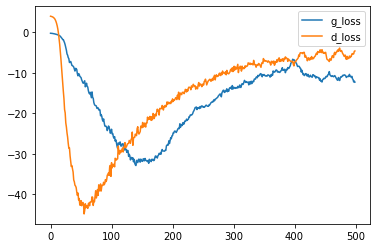

In [11]:
plt.plot(g.logger_.history["g_loss"], label="g_loss")
plt.plot(g.logger_.history["d_loss"], label="d_loss")
plt.legend()

### Sample results

In [12]:
def show_colors(colors, scale=2, labels=[]):
    def show_color(color_array, axis, label=None):
        axis.imshow([[color_array]])
        axis.set_axis_off()
        if label:
            axis.set_title(label)
        
    n = len(colors) // 3
    
    fig, axs = plt.subplots(1, n, figsize=(n*scale, scale))
    for i, label in itertools.zip_longest(range(n), labels):
        color = colors[3*i : 3*i + 3]
        show_color(color, axs[i], label)
        
    plt.tight_layout()
    plt.show()

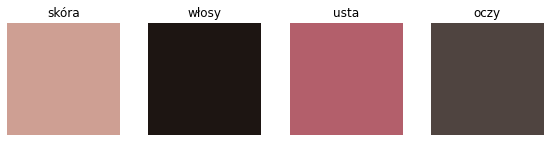

In [13]:
y = Y[np.random.choice(len(Y))][None, ...]
y_show = Y_scaler.inverse_transform(y).astype(np.uint8)
y_show = f.Rearrange("n (f fs) -> n f fs", fs=3)(y_show)
y_show = conversion.LabToRgb(y_show)
y_show = f.Rearrange("n f fs -> n (f fs)", fs=3)(y_show)
show_colors(y_show[0], labels=["skóra", "włosy", "usta", "oczy"])

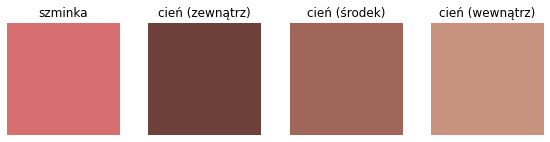

In [14]:
x_fake = g.sample(y)
x_fake = X_scaler.inverse_transform(x_fake).astype(np.uint8)
x_fake = f.Rearrange("n (f fs) -> n f fs", fs=3)(x_fake)
x_fake = conversion.LabToRgb(x_fake)
x_fake = f.Rearrange("n f fs -> n (f fs)", fs=3)(x_fake)
show_colors(x_fake[0], labels=["szminka", "cień (zewnątrz)", "cień (środek)", "cień (wewnątrz)"])

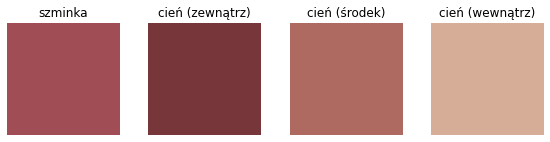

In [15]:
x_real = df.iloc[np.where((Y == y).all(axis=1))[0], 13:].values.astype(np.uint8)[0]
show_colors(x_real, labels=["szminka", "cień (zewnątrz)", "cień (środek)", "cień (wewnątrz)"])